# WLASL Training

The Word-Level American Sign Language 100 (WLASL100) dataset consists of approximately 2,038 videos of around 100 most frequent words from the WLASL dataset.

For training this dataset, we will use a LSTM model as a baseline for ASL word detection.

## Set-Up

In [50]:
import os
import glob
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd

In [39]:
DATA_ROOT = "wlasl100_features"
BATCH_SIZE = 32
EPOCHS = 80
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-4
CLIP_GRAD = 0.5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

In [20]:
# getting label map from preprocessing
label_map_path = os.path.join(DATA_ROOT, "label_map.json")
if os.path.exists(label_map_path):
    with open(label_map_path, 'r') as f:
        label_map = json.load(f)
    NUM_CLASSES = len(label_map)
    print(f"Found {NUM_CLASSES} classes in label_map.")
else:
    raise FileNotFoundError("Error: label_map.json not found")

Found 100 classes in label_map.


The class below defines the WLASL 100 dataset, with a function to easily get features and labels.

In [21]:
class WLASL100Dataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.split_dir = os.path.join(root_dir, split)
        self.files = []
        
        for root, _, filenames in os.walk(self.split_dir):
            for filename in filenames:
                if filename.endswith('.npy'):
                    self.files.append(os.path.join(root, filename))

        if len(self.files) == 0:
            print(f"Warning: No files found in {self.split_dir}.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        
        # load dictionary
        data_dict = np.load(path, allow_pickle=True).item()
        
        # extract features; shape: (30, 225) -> float32
        features = torch.tensor(data_dict['data'], dtype=torch.float32)
        
        # extract label
        label = torch.tensor(data_dict['label'], dtype=torch.long)
        
        return features, label

In [22]:
train_ds = WLASL100Dataset(DATA_ROOT, "train")
val_ds   = WLASL100Dataset(DATA_ROOT, "val")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

## LSTM Model

In [63]:
class LSTM(nn.Module):
    def __init__(self, input_dim=225, hidden_dim=256, num_classes=100):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=3,
            batch_first=True,
            dropout=0.4,
            bidirectional=True
        )
        
        # classifier layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        # x shape: [batch, 30, 225]
        lstm_out, _ = self.lstm(x)
        x = torch.mean(lstm_out, dim=1) 
        
        logits = self.fc(x)
        return logits

model = LSTM(num_classes=NUM_CLASSES).to(DEVICE)
print(model)

LSTM(
  (lstm): LSTM(225, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)


### Training

In [64]:
# computes accuracy for 'k' top predictions
def get_topk_counts(output, target, topk=(1, 5, 10)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.item())
        return res

In [65]:
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

history = {
    'train_loss': [], 'val_loss': [],
    'train_top1': [], 'train_top5': [], 'train_top10': [],
    'val_top1': [],   'val_top5': [],   'val_top10': []
    }

print("Starting Training...")

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # --- train ---
    model.train()
    train_loss = 0.0
    t_correct_1, t_correct_5, t_correct_10 = 0, 0, 0
    t_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        optimizer.step()
        
        train_loss += loss.item()
        
        # calculate top-k accuracy
        c1, c5, c10 = get_topk_counts(outputs, labels, topk=(1, 5, 10))
        t_correct_1 += c1
        t_correct_5 += c5
        t_correct_10 += c10
        t_total += labels.size(0)

    avg_t_loss = train_loss / len(train_loader)
    acc_t_1 = 100 * t_correct_1 / t_total
    acc_t_5 = 100 * t_correct_5 / t_total
    acc_t_10 = 100 * t_correct_10 / t_total
    
    # --- validation ---
    model.eval()
    val_loss = 0.0
    v_correct_1, v_correct_5, v_correct_10 = 0, 0, 0
    v_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = ce_loss(outputs, labels)
            val_loss += loss.item()

            c1, c5, c10 = get_topk_counts(outputs, labels, topk=(1, 5, 10))
            v_correct_1 += c1
            v_correct_5 += c5
            v_correct_10 += c10
            v_total += labels.size(0)
            
    avg_v_loss = val_loss / len(val_loader)
    acc_v_1 = 100 * v_correct_1 / v_total
    acc_v_5 = 100 * v_correct_5 / v_total
    acc_v_10 = 100 * v_correct_10 / v_total

    scheduler.step(avg_v_loss)
    
    # save history
    history['train_top1'].append(acc_t_1)
    history['train_top5'].append(acc_t_5)
    history['train_top10'].append(acc_t_10)
    history['train_loss'].append(avg_t_loss)
    history['val_top1'].append(acc_v_1)
    history['val_top5'].append(acc_v_5)
    history['val_top10'].append(acc_v_10)
    history['val_loss'].append(avg_v_loss)
    
    if epoch > 0 and acc_v_1 > max(history['val_top1'][:-1]):
        torch.save(model.state_dict(), "best_model_lstm.pth")

    elapsed = time.time() - start_time
    print(f"Ep {epoch+1}/{EPOCHS} | {elapsed:.0f}s | Loss: {avg_t_loss:.3f} | "
          f"Train: {acc_t_1:.1f}% | "
          f"Val T1: {acc_v_1:.1f}% T5: {acc_v_5:.1f}% T10: {acc_v_10:.1f}%")

print("Training Done")
torch.save(model.state_dict(), "wlasl100_model.pth")
print("Model saved as wlasl100_model.pth")

Starting Training...
Ep 1/80 | 5s | Loss: 4.553 | Train: 1.6% | Val T1: 1.7% T5: 9.9% T10: 17.8%
Ep 2/80 | 4s | Loss: 4.334 | Train: 1.9% | Val T1: 2.5% T5: 10.3% T10: 21.1%
Ep 3/80 | 5s | Loss: 4.224 | Train: 2.8% | Val T1: 3.7% T5: 13.2% T10: 26.4%
Ep 4/80 | 4s | Loss: 4.130 | Train: 3.8% | Val T1: 6.2% T5: 16.5% T10: 29.3%
Ep 5/80 | 5s | Loss: 4.005 | Train: 6.5% | Val T1: 7.4% T5: 23.6% T10: 35.1%
Ep 6/80 | 5s | Loss: 3.858 | Train: 7.3% | Val T1: 7.0% T5: 22.3% T10: 36.8%
Ep 7/80 | 4s | Loss: 3.743 | Train: 9.3% | Val T1: 7.9% T5: 27.7% T10: 41.7%
Ep 8/80 | 4s | Loss: 3.612 | Train: 9.9% | Val T1: 9.1% T5: 28.5% T10: 43.8%
Ep 9/80 | 5s | Loss: 3.500 | Train: 13.1% | Val T1: 10.7% T5: 27.7% T10: 48.8%
Ep 10/80 | 4s | Loss: 3.407 | Train: 15.2% | Val T1: 10.7% T5: 35.5% T10: 52.5%
Ep 11/80 | 4s | Loss: 3.283 | Train: 16.8% | Val T1: 10.7% T5: 37.2% T10: 56.6%
Ep 12/80 | 5s | Loss: 3.206 | Train: 17.8% | Val T1: 14.5% T5: 35.1% T10: 55.8%
Ep 13/80 | 5s | Loss: 3.112 | Train: 20.3% | 

Now that training has finished, we can visualize it:

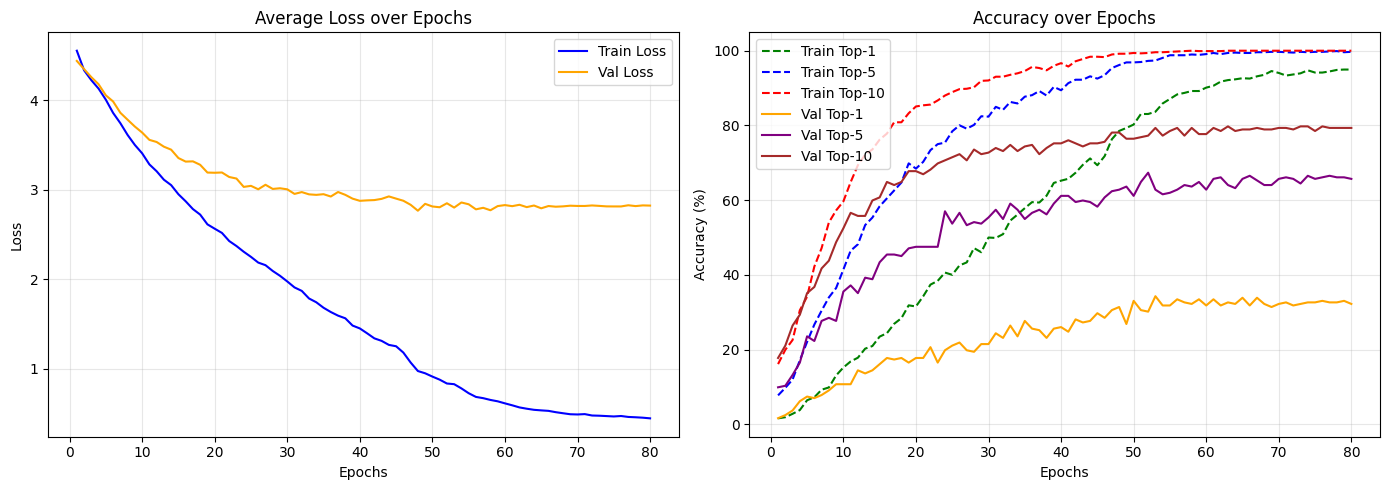

In [67]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='orange')
    plt.title('Average Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # accuracy (top 1, 5, 10)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_top1'], label='Train Top-1', color='green', linestyle='--')
    plt.plot(epochs, history['train_top5'], label='Train Top-5', color='blue', linestyle='--')
    plt.plot(epochs, history['train_top10'], label='Train Top-10', color='red', linestyle='--')
    plt.plot(epochs, history['val_top1'], label='Val Top-1', color='orange')
    plt.plot(epochs, history['val_top5'], label='Val Top-5', color='purple')
    plt.plot(epochs, history['val_top10'], label='Val Top-10', color='brown')
        
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

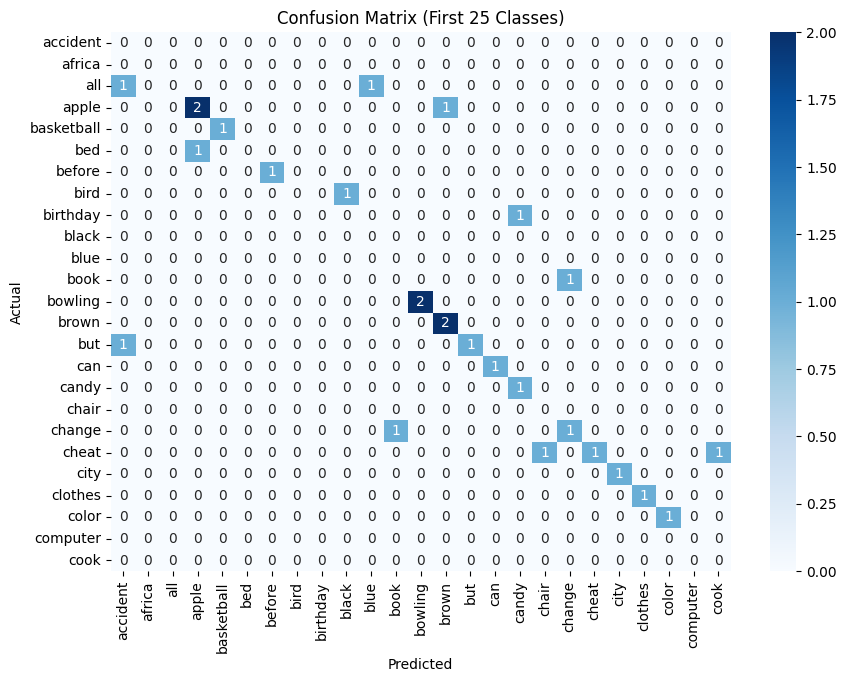

In [73]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

with open(f"{DATA_ROOT}/label_map.json", "r") as f:
    label_map = json.load(f)
    idx_to_word = {v: k for k, v in label_map.items()}
    NUM_CLASSES = len(label_map)

def plot_confusion_matrix(y_true, y_pred, classes, limit=20):
    mask = (y_true < limit) & (y_pred < limit)
    y_true_sub = y_true[mask]
    y_pred_sub = y_pred[mask]

    class_names = [classes[i] for i in range(limit)]

    cm = confusion_matrix(y_true_sub, y_pred_sub, labels=range(limit))

    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (First {limit} Classes)')
    plt.show()

plot_confusion_matrix(np.array(all_labels), np.array(all_preds), idx_to_word, limit=25)


### Inference

In [74]:
model.eval()

test_ds = WLASL100Dataset(DATA_ROOT, "test")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Running inference on {len(test_ds)} test videos...")

# inference
all_test_preds = []
all_test_labels = []
all_top5_preds = []
all_top10_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits = model(inputs)
        
        # top-1 prediction
        _, pred_1 = torch.max(logits, 1)
        
        # top-5 prediction
        _, pred_5 = torch.topk(logits, 5, dim=1)

        # top-10 prediction
        _, pred_10 = torch.topk(logits, 10, dim=1)
        
        # Store results
        all_test_preds.extend(pred_1.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        all_top5_preds.extend(pred_5.cpu().numpy())
        all_top10_preds.extend(pred_10.cpu().numpy())

# metrics
all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)
all_top5_preds = np.array(all_top5_preds)
all_top10_preds = np.array(all_top10_preds)

# top-1 accuracy
correct_1 = (all_test_preds == all_test_labels).sum()
acc_1 = correct_1 / len(all_test_labels) * 100

# top-5 accuracy
correct_5 = 0
for i in range(len(all_test_labels)):
    if all_test_labels[i] in all_top5_preds[i]:
        correct_5 += 1
acc_5 = correct_5 / len(all_test_labels) * 100

# top-10 accuracy
correct_10 = 0
for i in range(len(all_test_labels)):
    if all_test_labels[i] in all_top10_preds[i]:
        correct_10 += 1
acc_10 = correct_10 / len(all_test_labels) * 100

print(f"\n>>> FINAL TEST RESULTS <<<")
print(f"Top-1 Accuracy: {acc_1:.2f}%")
print(f"Top-5 Accuracy: {acc_5:.2f}%")
print(f"Top-10 Accuracy: {acc_10:.2f}%")

Running inference on 200 test videos...


100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


>>> FINAL TEST RESULTS <<<
Top-1 Accuracy: 22.50%
Top-5 Accuracy: 57.50%
Top-10 Accuracy: 74.00%


We can see the inference results above, but we can also visualize them below.

>>> MODEL PERFORMANCE METRICS <<<


,Metric,Score
0,Top-1 Accuracy,22.50%
1,Top-5 Accuracy,57.50%
2,Top-10 Accuracy,74.00%


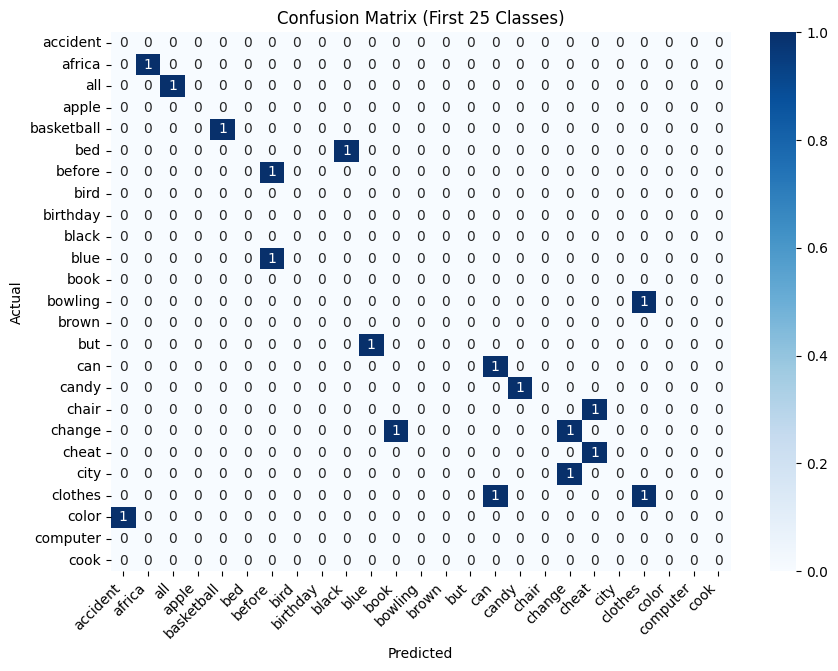

In [77]:
def visualize_inference_results(preds, labels, idx_to_word, acc_1, acc_5, acc_10):
    # top-k accuracies
    results_data = {
        'Metric': ['Top-1 Accuracy', 'Top-5 Accuracy', 'Top-10 Accuracy'],
        'Score': [f"{acc_1:.2f}%", f"{acc_5:.2f}%", f"{acc_10:.2f}%"]
    }
    df_results = pd.DataFrame(results_data)
    
    print(">>> MODEL PERFORMANCE METRICS <<<")
    display(df_results)
    
    # confusion matrix
    limit = 25
    mask = (labels < limit) & (preds < limit)
    
    if mask.sum() > 0:
        cm = confusion_matrix(labels[mask], preds[mask], labels=range(limit))
        class_names = [idx_to_word[i] for i in range(limit)]
        
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        
        plt.title(f'Confusion Matrix (First {limit} Classes)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        print(f"Not enough data in the first {limit} classes to plot a matrix.")

visualize_inference_results(all_test_preds, all_test_labels, idx_to_word, acc_1, acc_5, acc_10)